In [ ]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [ ]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

Model: "vae_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 2), (None, 2), │       201,988 │
│                                 │ (None, 2))             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       202,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - kl_loss: 12.4218 - reconstruction_loss: 341.0660 - total_loss: 353.4879 - val_kl_loss: 6.8502 - val_reconstruction_loss: 280.4761 - val_total_loss: 287.3263
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - kl_loss: 6.7065 - reconstruction_loss: 275.8585 - total_loss: 282.5650 - val_kl_loss: 6.0720 - val_reconstruction_loss: 275.6585 - val_total_loss: 281.7305
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - kl_loss: 6.2545 - reconstruction_loss: 271.6101 - total_loss: 277.8646 - val_kl_loss: 6.2118 - val_reconstruction_loss: 271.8066 - val_total_loss: 278.0183
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 6.2047 - reconstruction_loss: 268.7666 - total_loss: 274.9713 - val_kl_loss: 6.3889 - val_reconstruction_loss: 269.4730 - val_total_loss: 275.8618
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - kl_loss: 6.2067 - reconstruction_loss: 266.5022 - total_loss: 272.7089 - val_kl_loss: 6.2476 - va

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 784)            │        50,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,200 (395.31 KB)

 Trainable params: 101,200 (395.31 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.4267 - val_loss: 0.3137
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3050 - val_loss: 0.2943
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2888 - val_loss: 0.2857
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2818 - val_loss: 0.2818
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2784 - val_loss: 0.2794
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2762 - val_loss: 0.2777
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2746 - val_loss: 0.2765
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2735 - val_loss: 0.2757
Epoch 9/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2728 - val_loss: 0.2752
Epoch 10/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2722 - val_loss: 0.2747
Epoch 11/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2718 - val_loss: 0.2743
Epoch 12/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


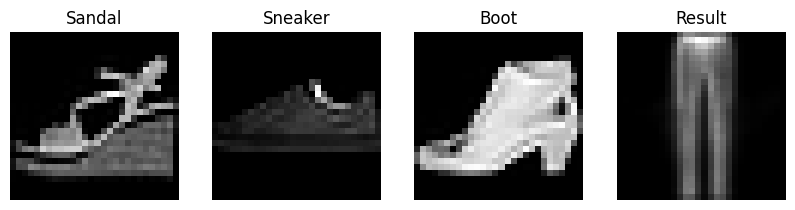

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


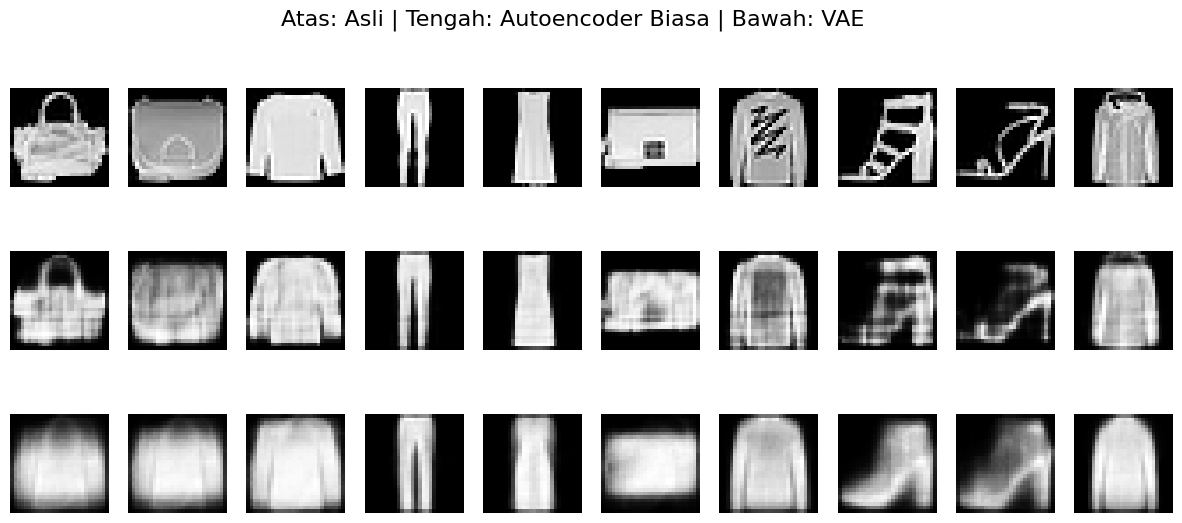

In [5]:
# ===========================================
# 0. IMPORT & LOAD DATA
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Import tensorflow
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import losses # Import losses module

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test  = x_test.astype("float32") / 255.
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# ===========================================
# 1. BANGUN VAE (menggunakan Model subclass)
# ===========================================

latent_dim = 2

# Encoder VAE - Functional API
encoder_input = Input(shape=(28,28,1), name="encoder_input")
x = layers.Flatten()(encoder_input)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

# Decoder VAE - Functional API
decoder_input = Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(256, activation="relu")(decoder_input)
x = layers.Dense(28*28, activation="sigmoid")(x)
decoder_output = layers.Reshape((28,28,1))(x)
decoder = Model(decoder_input, decoder_output, name="decoder")

# VAE Model (subclassing tf.keras.Model) untuk penanganan loss yang tepat
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Reconstruction loss (binary_crossentropy cocok untuk rekonstruksi gambar)
        reconstruction_loss = tf.reduce_sum(
            losses.binary_crossentropy(data, reconstruction),
            axis=[1, 2] # Sum over H, W untuk setiap gambar
        )
        reconstruction_loss = tf.reduce_mean(reconstruction_loss) # Mean over batch

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1 # Sum over latent dimensions
        )
        kl_loss = tf.reduce_mean(kl_loss) # Mean over batch

        total_loss = reconstruction_loss + kl_loss

        # Tambahkan losses ini ke model
        self.add_loss(total_loss)

        # Perbarui metrics (opsional, tapi bagus untuk monitoring)
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return reconstruction # Output utama VAE untuk model.fit, biasanya rekonstruksi

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam") # Tidak perlu argumen loss karena ditambahkan secara internal
vae.summary()

# Latih VAE - target biasanya input itu sendiri untuk VAE
vae.fit(x_train, x_train, epochs=15, batch_size=128, validation_split=0.1)

# ===========================================
# 2. AUTOENCODER BIASA UNTUK PERBANDINGAN
# ===========================================
input_img2 = Input(shape=(28,28,1))

y = layers.Flatten()(input_img2)
encoded = layers.Dense(64, activation="relu")(y)
decoded = layers.Dense(784, activation="sigmoid")(encoded)
decoded = layers.Reshape((28,28,1))(decoded)

autoencoder = Model(input_img2, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

autoencoder.fit(x_train, x_train, epochs=15, batch_size=128, validation_split=0.1)

# ===========================================
# 3. LATENT SPACE ARITHMETIC (FASHION-MNIST)
# ===========================================

def get_z(img):
    img = np.expand_dims(img, 0)
    z_mean, z_log_var, z = encoder.predict(img)
    return z_mean  # use expected latent vector

def sample_class(label):
    idx = np.where(y_test == label)[0]
    return x_test[np.random.choice(idx)]

# Contoh: sandal + sneaker - boot
sandal = sample_class(5)   # sandal
sneaker = sample_class(7)  # sneaker
boot = sample_class(9)     # boot

z_sandal = get_z(sandal)
z_sneaker = get_z(sneaker)
z_boot = get_z(boot)

z_result = z_sandal + (z_sneaker - z_boot)

generated = decoder.predict(z_result)

plt.figure(figsize=(10,3))
plt.subplot(1,4,1); plt.imshow(sandal.squeeze(), cmap='gray'); plt.title("Sandal"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(sneaker.squeeze(), cmap='gray'); plt.title("Sneaker"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(boot.squeeze(), cmap='gray'); plt.title("Boot"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(generated.squeeze(), cmap='gray'); plt.title("Result"); plt.axis("off")
plt.show()

# ===========================================
# 4. PERBANDINGAN REKONSTRUKSI VAE VS AE
# ===========================================

n = 10
idx = np.random.choice(len(x_test), n)
samples = x_test[idx]

# Rekonstruksi
z_mean, z_log_var, z = encoder.predict(samples)
vae_recon = decoder.predict(z)
ae_recon = autoencoder.predict(samples)

plt.figure(figsize=(15,6))
for i in range(n):
    # Original
    plt.subplot(3, n, i+1)
    plt.imshow(samples[i].squeeze(), cmap='gray')
    plt.axis('off')

    # Autoencoder biasa
    plt.subplot(3, n, n+i+1)
    plt.imshow(ae_recon[i].squeeze(), cmap='gray')
    plt.axis('off')

    # VAE
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(vae_recon[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle("Atas: Asli | Tengah: Autoencoder Biasa | Bawah: VAE", fontsize=16)
plt.show()

In [ ]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=15, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 219s 459ms/step - kl_loss: 4.1896 - reconstruction_loss: 395.4251 - total_loss: 399.6147 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 252s 439ms/step - kl_loss: 5.9905 - reconstruction_loss: 266.4504 - total_loss: 272.4409 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 209s 446ms/step - kl_loss: 6.0738 - reconstruction_loss: 262.0675 - total_loss: 268.1412 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 206s 439ms/step - kl_loss: 6.1302 - reconstruction_loss: 259.4836 - total_loss: 265.6138 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 210s 448ms/step - kl_loss: 6.1955 - reconstruction_loss: 258.0796 - tota

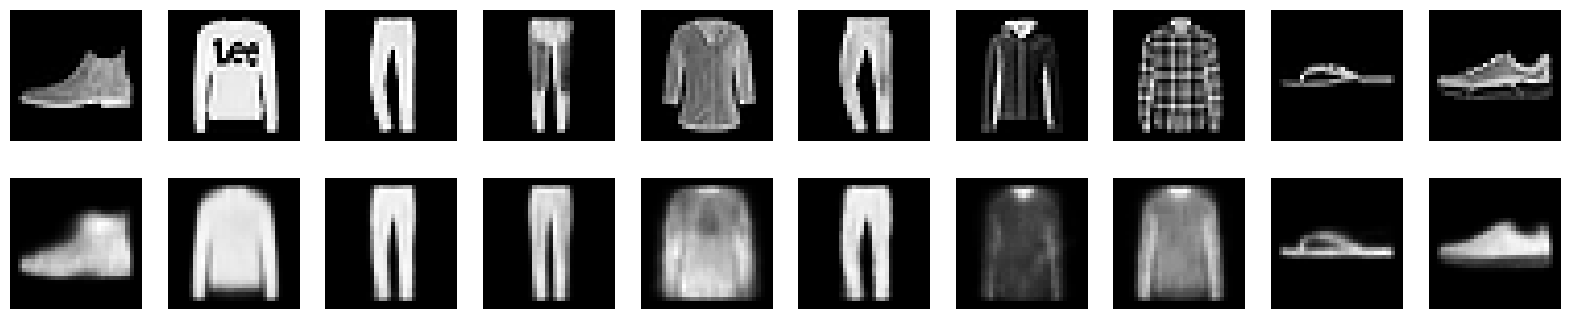

In [ ]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


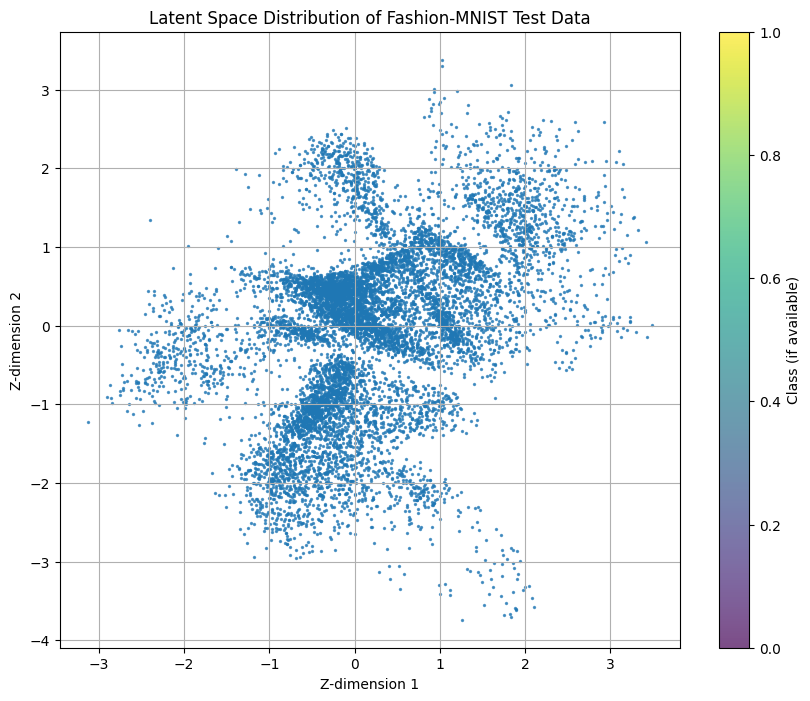

In [ ]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [ ]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [ ]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[-0.64116436  1.4698915 ]
 [-0.11087556 -0.3479636 ]
 [ 1.7839694  -2.6202655 ]
 [ 2.5299788  -1.1723716 ]
 [ 0.3805128   0.14784648]]


## Visualize Latent Space Distribution by Class



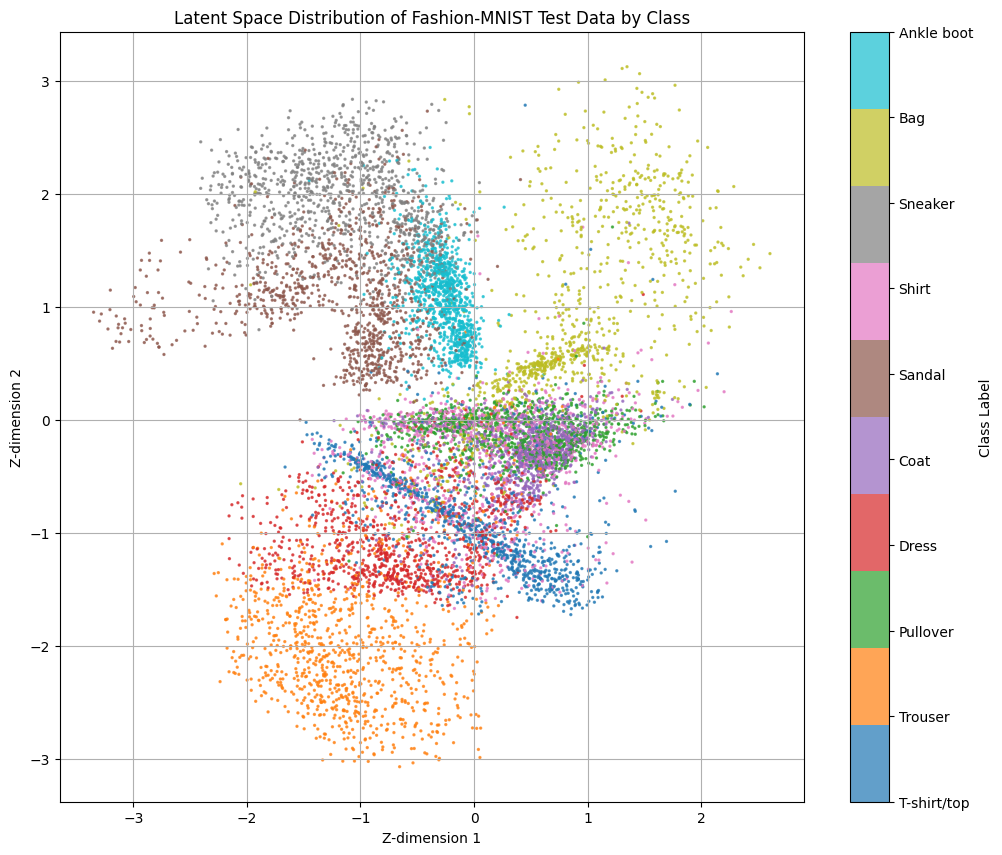

In [ ]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()